In [11]:
#THIS ONE IS THE FINAL ONE


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, balanced_accuracy_score, confusion_matrix,
    precision_recall_curve
)
from xgboost import XGBClassifier
from tqdm import tqdm

# Load data
# df= pd.read_excel("excel_files/test_T1.xlsx", na_values=["#NULL!", "NULL", "N/A"], decimal=",")
# df = df.drop(columns=["helper"], errors="ignore")
# df= df.apply(pd.to_numeric, errors="coerce")

target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts', 'T1_YSR_sad_binary', 'T1_YSR_swd_binary',
       'T1_YSR_ssc_binary', 'T1_YSR_ssp_binary', 'T1_YSR_stp_binary',
       'T1_YSR_sap_binary', 'T1_YSR_srb_binary', 'T1_YSR_sab_binary',
       'T1_YSR_sip_binary', 'T1_YSR_sep_binary',
       'T1_YSR_sts_binary'
]

#df[target_columns] = df[target_columns].replace(2, 1)

# Define acoustic feature columns
feature_cols = df.columns[90:]

results = []

# Range of k values to test
k_values = [10, 25, 50, 75, 100]

for target in tqdm(target_columns):
    data = df[[target] + list(feature_cols)].dropna()
    y = data[target]
    X = data[feature_cols]

    # Train/test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Preprocess: scale
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation to select best k
    best_k = None
    best_f1 = -np.inf

    for k in k_values:
        f1s = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X_train_scaled, y_train_full):
            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

            selector = SelectKBest(mutual_info_classif, k=k)
            X_tr_sel = selector.fit_transform(X_tr, y_tr)
            X_val_sel = selector.transform(X_val)

            neg, pos = np.bincount(y_tr)
            scale = neg / pos

            model = XGBClassifier(
                scale_pos_weight=scale,
                use_label_encoder=False,
                eval_metric='aucpr',
                tree_method='gpu_hist',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                random_state=42
            )
            model.fit(X_tr_sel, y_tr)
            y_val_pred = model.predict(X_val_sel)
            f1s.append(f1_score(y_val, y_val_pred, zero_division=0))

        avg_f1 = np.mean(f1s)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_k = k

    # Retrain with best k on full training data
    selector = SelectKBest(mutual_info_classif, k=best_k)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train_full)
    X_test_sel = selector.transform(X_test_scaled)

    # 🔧 Extract selected feature names
    selected_features = X.columns[selector.get_support()].tolist()

    neg, pos = np.bincount(y_train_full)
    ratio = neg / pos

    scale = ratio if ratio > 1.5 else 1  # Apply only for significant imbalance

    model = XGBClassifier(
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        device='cuda',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )

    model.fit(X_train_sel, y_train_full)
    y_proba = model.predict_proba(X_test_sel)[:, 1]

    # 🔧 Get feature importances from model
    importances = model.feature_importances_
    feature_importance_dict = dict(zip(selected_features, importances))
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    top5_features = sorted_importances[:5]

    top5_names = [f for f, _ in top5_features]
    top5_vals = [round(float(v), 4) for _, v in top5_features]
    top5_str = "; ".join([f"{name}: {val}" for name, val in zip(top5_names, top5_vals)])


    # Threshold tuning to achieve >=70% recall
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    idxs = np.where(recalls >= 0.7)[0]
    if len(idxs) > 0:
        precision_at_70recall = np.max(precisions[idxs])
    else:
        precision_at_70recall = np.nan

    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0. and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
    else:
        threshold = 0.5  # fallback

    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "Target": target,
        "Best_k": best_k,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Selected_Features": "; ".join(selected_features),
        "Top5_Important_Features": top5_str
    })


# Compile results
results_df = pd.DataFrame(results)
print(results_df)

# Optional: Save to Excel
# results_df.to_excel("xgboost_bestk_final_results.xlsx", index=False)


  0%|          | 0/22 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [13:42:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


               Target  Best_k        F1  Balanced Accuracy  Precision  \
0     T1_YSR_93_98_ad      75  0.428571           0.640741   0.750000   
1     T1_YSR_93_98_wd     100  0.418605           0.617347   0.310345   
2     T1_YSR_93_98_sc      75  0.300000           0.593939   0.272727   
3     T1_YSR_93_98_sp      10  0.215385           0.552632   0.120690   
4     T1_YSR_93_98_tp      75  0.461538           0.669318   0.600000   
5     T1_YSR_93_98_ap      10  0.470588           0.654422   0.421053   
6     T1_YSR_93_98_rb      10  0.285714           0.687500   0.166667   
7     T1_YSR_93_98_ab      10  0.085106           0.647541   0.044444   
8     T1_YSR_93_98_ip     100  0.517647           0.500000   0.349206   
9     T1_YSR_93_98_ep      25  0.400000           0.638889   0.500000   
10    T1_YSR_93_98_ts      10  0.450704           0.557545   0.296296   
11  T1_YSR_sad_binary      50  0.682927           0.613725   0.538462   
12  T1_YSR_swd_binary     100  0.652632           0

In [6]:
results_df

,Target,F1,Balanced Accuracy,Precision,Recall,Accuracy,Precision@70%Recall,TP,TN,FP,FN,Threshold,k,Selected Features,Feature Importances
0,T1_YSR_93_98_ad,0.315789,0.594444,0.333333,0.300000,0.796875,NaN,3,48,6,7,0.328271,50,"[t1_stdlogE, t1_avgMFCCon_7, t1_avgDDMFCCoff_8...","{'t1_stdlogE': 2.395508289337158, 't1_avgMFCCo..."
1,T1_YSR_93_98_wd,0.210526,0.540816,0.400000,0.142857,0.761905,NaN,2,46,3,12,0.500000,100,"[t1_kurtosisDDF0, t1_kurtosisapq, t1_kurtosisp...","{'t1_kurtosisDDF0': 1.8071848154067993, 't1_ku..."
2,T1_YSR_93_98_sc,0.333333,0.612121,0.333333,0.333333,0.812500,NaN,3,49,6,6,0.199615,30,"[t1_skewnessDF0, t1_avgBBEon_6, t1_avgBBEon_15...","{'t1_skewnessDF0': 1.938474416732788, 't1_avgB..."
3,T1_YSR_93_98_sp,0.166667,0.536341,0.200000,0.142857,0.843750,NaN,1,53,4,6,0.500000,50,"[t1_stdapq, t1_avgMFCCon_1, t1_avgDMFCCon_5, t...","{'t1_stdapq': 1.029375433921814, 't1_avgMFCCon..."
4,T1_YSR_93_98_tp,0.166667,0.535227,0.250000,0.125000,0.841270,NaN,1,52,3,7,0.500000,100,"[t1_skewnessDF0, t1_avgBBEon_18, t1_avgMFCCon_...","{'t1_skewnessDF0': 1.165035605430603, 't1_avgB..."
5,T1_YSR_93_98_ap,0.368421,0.570068,0.304348,0.466667,0.625000,NaN,7,33,16,8,0.187546,50,"[t1_avgBBEon_18, t1_avgDDMFCCon_1, t1_avgDDMFC...","{'t1_avgBBEon_18': 1.1423739194869995, 't1_avg..."
6,T1_YSR_93_98_rb,0.000000,0.464286,0.000000,0.000000,0.825397,NaN,0,52,4,7,0.500000,30,"[t1_avgMFCCon_2, t1_avgMFCCon_9, t1_stdDMFCCon...","{'t1_avgMFCCon_2': 1.6700494289398193, 't1_avg..."
7,T1_YSR_93_98_ab,0.000000,0.500000,0.000000,0.000000,0.968254,NaN,0,61,0,2,0.500000,100,"[t1_stdlogE, t1_avgBBEon_1, t1_avgBBEon_12, t1...","{'t1_avgBBEon_1': 0.4134331941604614, 't1_avgB..."
8,T1_YSR_93_98_ip,0.545455,0.562639,0.381818,0.954545,0.444444,0.381818,21,7,34,1,0.046414,100,"[t1_skewnessJitter, t1_skewnessShimmer, t1_kur...","{'t1_skewnessJitter': 1.657456636428833, 't1_s..."
9,T1_YSR_93_98_ep,0.470588,0.685185,0.500000,0.444444,0.857143,NaN,4,50,4,5,0.202201,50,"[t1_avgMFCCon_2, t1_avgMFCCon_9, t1_avgDMFCCon...","{'t1_avgMFCCon_2': 1.3867541551589966, 't1_avg..."


In [1]:
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn import FunctionSampler
from collections import Counter

from joblib import Parallel, delayed


In [282]:
import pandas as pd
df = pd.read_excel("excel_files/test_T1.xlsx",na_values=["#NULL!", "NULL", "N/A"], decimal=",")
df = df.drop(columns=["helper"])
df = df.apply(pd.to_numeric, errors="coerce")
target_columns = [
    'T1_YSR_93_98_ad', 'T1_YSR_93_98_wd', 'T1_YSR_93_98_sc',
    'T1_YSR_93_98_sp', 'T1_YSR_93_98_tp', 'T1_YSR_93_98_ap',
    'T1_YSR_93_98_rb', 'T1_YSR_93_98_ab', 'T1_YSR_93_98_ip',
    'T1_YSR_93_98_ep', 'T1_YSR_93_98_ts'
]

df[target_columns] = df[target_columns].replace(2, 1)

In [9]:
df.columns[90:]

Index(['t1_avgDF0', 't1_avgDDF0', 't1_avgJitter', 't1_avgShimmer', 't1_avgapq',
       't1_avgppq', 't1_avglogE', 't1_stdDF0', 't1_stdDDF0', 't1_stdJitter',
       ...
       't1_paa_deltachroma_7_skew', 't1_paa_deltachroma_7_kurtosis',
       't1_paa_deltachroma_8_mean', 't1_paa_deltachroma_8_std',
       't1_paa_deltachroma_8_min', 't1_paa_deltachroma_8_max',
       't1_paa_deltachroma_8_skew', 't1_paa_deltachroma_8_kurtosis',
       't1_paa_deltachroma_9_mean', 't1_paa_deltachroma_9_std'],
      dtype='object', length=999)

In [3]:
####NEW LABELS 50-50 USING MEDIAN

targets = ['T1_YSR_sad', 'T1_YSR_swd', 'T1_YSR_ssc',
           'T1_YSR_ssp', 'T1_YSR_stp', 'T1_YSR_sap',
           'T1_YSR_srb', 'T1_YSR_sab', 'T1_YSR_sip',
           'T1_YSR_sep', 'T1_YSR_sts']

insert_position = 79
for target in targets:
    median_value = df[target].median()
    binary_label = (df[target] > median_value).astype(int)
    df.insert(loc=insert_position, column=f"{target}_binary", value=binary_label)
    insert_position += 1  # Shift for the next insert

In [4]:
targets_5050 = ['T1_YSR_sad_binary', 'T1_YSR_swd_binary',
       'T1_YSR_ssc_binary', 'T1_YSR_ssp_binary', 'T1_YSR_stp_binary',
       'T1_YSR_sap_binary', 'T1_YSR_srb_binary', 'T1_YSR_sab_binary',
       'T1_YSR_sip_binary', 'T1_YSR_sep_binary',
       'T1_YSR_sts_binary']

In [19]:
def evaluate_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, min_precision, min_recall, recall_target):
    model_fold = clone(model)
    model_fold.fit(X_train_fold, y_train_fold)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba_val)
    f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= min_precision and r >= min_recall]

    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1s[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]
    else:
        threshold = 0.5

    y_pred_val = (y_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val_fold, y_pred_val, zero_division=0)
    precision = precision_score(y_val_fold, y_pred_val, zero_division=0)
    recall = recall_score(y_val_fold, y_pred_val, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    prec_at_70 = precision if recall >= recall_target else np.nan

    return f1, prec_at_70, threshold, bal_acc

# Updated cross_val_with_threshold_tuning with n_jobs
def cross_val_with_threshold_tuning(model, X, y, min_precision=0.3, min_recall=0.3, recall_target=0.7, n_splits=5, n_jobs=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_fold)(
            model,
            X.iloc[train_idx], y.iloc[train_idx],
            X.iloc[val_idx], y.iloc[val_idx],
            min_precision, min_recall, recall_target
        )
        for train_idx, val_idx in kf.split(X, y)
    )

    f1_scores, precisions_at_70recall, thresholds_used, bal_accs = zip(*results)

    return {
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Balanced Accuracy Mean": np.mean(bal_accs),
        "Balanced Accuracy Std": np.std(bal_accs),
        "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
        "Thresholds Used (Mean)": np.mean(thresholds_used)
    }

from imblearn.over_sampling import SMOTE

def safe_smote(X, y, random_state=42):
    # Count minority class samples
    from collections import Counter
    counter = Counter(y)
    min_class_count = min(counter.values())

    # Avoid errors by capping k_neighbors
    k = min(3, min_class_count - 1) if min_class_count > 1 else 1

    return SMOTE(k_neighbors=k, random_state=random_state).fit_resample(X, y)

In [20]:
results = []

var_thresh = VarianceThreshold(threshold=0.0)
scaler = RobustScaler()
kbest = SelectKBest(score_func=mutual_info_classif, k=100)
pca = PCA(n_components=50)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy'
}

models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ])
    }

In [280]:
models_5050 = {
    "No FS": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "No FS - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "KBest": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KBest - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "PCA": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "PCA - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ])
}


In [285]:
cv_results = []

for target in tqdm(targets_5050):
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models_5050.items():
        metrics = cross_val_with_threshold_tuning(
            model, X_train, y_train,  # <- important: use training set only
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        cv_results.append({
            "Target": target,
            "Model": model_name,
            "F1 Mean": metrics["F1 Mean"],
            "F1 Std": metrics["F1 Std"],
            "Balanced Accuracy Mean": metrics["Balanced Accuracy Mean"],
            "Balanced Accuracy Std": metrics["Balanced Accuracy Std"],
            "Precision@70%Recall Mean": metrics["Precision@70%Recall Mean"],
            "Thresholds Used (Mean)": metrics["Thresholds Used (Mean)"]
        })

# Final results per model and target
cv_df_5050 = pd.DataFrame(cv_results)
#cv_df_5050.to_csv("505050_CV_T1_all_models_5050.csv", index=False)
# Example: find best model per target
best_models_df_5050 = cv_df_5050.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

In [257]:
final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models[model_name])

    # Prepare data
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    # Train/test split (held-out test set)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit on train set
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Precision-Recall Curve & Threshold Tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [
        i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1]))
        if p >= 0.3 and r >= 0.3
    ]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5  # fallback
        best_f1 = np.nan

    # Final prediction using selected threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)
    # Compute precision@70% recall from the full PR curve
    recall_target = 0.7
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= recall_target]
    if valid_idxs_70:
        precision_at_70recall = max([precisions[i] for i in valid_idxs_70])
    else:
        precision_at_70recall = np.nan


    # Confusion matrix and metrics
    acc = accuracy_score(y_test, y_pred)
    precision = prec_at_thresh
    recall = recall_at_thresh
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

# Convert to DataFrame
final_results_df_5050 = pd.DataFrame(final_results)
final_results_df_5050.to_csv("505050_FINAL_TEST_t1_5050.csv", index=False)

/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [286]:
final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models_5050[model_name])

    # Prepare data
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit model
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Threshold tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5
        best_f1 = np.nan

    # Predict with threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

    # Precision at 70% recall
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= 0.7]
    precision_at_70recall = max([precisions[i] for i in valid_idxs_70]) if valid_idxs_70 else np.nan

    # Confusion matrix
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # ---- Extract Top 3 Features (keep full names) ----
    if "PCA" not in model_name:
        try:
            coefs = model.named_steps["logreg"].coef_[0] if hasattr(model, "named_steps") else model.coef_[0]
            feature_names = X.columns
            sorted_indices = np.argsort(np.abs(coefs))[::-1][:3]
            top_features = [feature_names[i] for i in sorted_indices]
            top_coefs = [coefs[i] for i in sorted_indices]
        except Exception as e:
            print(f"⚠️ Feature extraction failed for {target}: {e}")
            top_features = [""] * 3
            top_coefs = [np.nan] * 3
    else:
        top_features = [""] * 3
        top_coefs = [np.nan] * 3

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec_at_thresh,
        "Recall": recall_at_thresh,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "Top Feature 1": top_features[0],
        "Top Feature 2": top_features[1],
        "Top Feature 3": top_features[2],
        "Coef 1": top_coefs[0],
        "Coef 2": top_coefs[1],
        "Coef 3": top_coefs[2],
    })

# Final dataframe
final_results_correctt1 = pd.DataFrame(final_results)
#final_results_df_5050.to_csv("FINAL_TEST_with_features_t1_5050.csv", index=False)

/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [14]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]

    # Extract short two-letter labels (e.g., "sab" → "ab")
    short_labels = [label.split('_')[1][1:] for label in target_order]

    # Metric configurations: (column, plot title, bar color, y-axis label)
    metrics = [
        ("F1 (test)", "F1 Score", "steelblue", "Score"),
        ("Balanced Accuracy (test)", "Balanced Accuracy", "sandybrown", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "seagreen", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=13)
    axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()


In [18]:
import pandas as pd
test= pd.read_csv("ALEXANDRA_XGBOOSTFEATURES_T1.csv")

In [19]:
test

,Target,Best_k,F1,Balanced Accuracy,Precision,Recall,Accuracy,Precision@70%Recall,TP,TN,FP,FN,Selected_Features,Top5_Important_Features
0,T1_YSR_93_98_ad,75,0.428571,0.640741,0.750000,0.300000,0.875000,0.266667,3,53,1,7,t1_avgJitter; t1_stdlogE; t1_skewnessDF0; t1_s...,t1_kurtosisDDMFCCon_11: 0.0452; t1_paa_deltasp...
1,T1_YSR_93_98_wd,100,0.418605,0.617347,0.310345,0.642857,0.603175,0.285714,9,29,20,5,t1_avgDF0; t1_kurtosisDDF0; t1_kurtosisapq; t1...,t1_skw1Eunvoiced: 0.0313; t1_skewnessDMFCCon_1...
2,T1_YSR_93_98_sc,75,0.300000,0.593939,0.272727,0.333333,0.781250,0.163636,3,47,8,6,t1_avgJitter; t1_stdJitter; t1_kurtosisppq; t1...,t1_kurtosisDDMFCCoff_11: 0.1072; t1_skwdurunvo...
3,T1_YSR_93_98_sp,10,0.215385,0.552632,0.120690,1.000000,0.203125,0.120690,7,6,51,0,t1_stdapq; t1_avgDMFCCoff_8; t1_stdBBEon_22; t...,t1_paa_deltachroma_8_skew: 0.1419; t1_paa_mfcc...
4,T1_YSR_93_98_tp,75,0.461538,0.669318,0.600000,0.375000,0.888889,0.162162,3,53,2,5,t1_avgDDF0; t1_kurtosislogE; t1_avgBBEon_18; t...,t1_kurtosisBBEon_5: 0.086; t1_stdtiltEvoiced: ...
5,T1_YSR_93_98_ap,10,0.470588,0.654422,0.421053,0.533333,0.718750,0.276596,8,38,11,7,t1_avgJitter; t1_avgBBEon_18; t1_F0tiltstd; t1...,t1_paa_deltamfcc_2_max: 0.1447; t1_avgJitter: ...
6,T1_YSR_93_98_rb,10,0.285714,0.687500,0.166667,1.000000,0.444444,0.166667,7,21,35,0,t1_avgMFCCoff_8; t1_stdDMFCCoff_7; t1_skewness...,t1_kurtosisDMFCCon_5: 0.1963; t1_paa_deltachro...
7,T1_YSR_93_98_ab,10,0.085106,0.647541,0.044444,1.000000,0.317460,0.044444,2,18,43,0,t1_stdDF2; t1_kurtosisBBEon_4; t1_kurtosisBBEo...,t1_stdDF2: 0.3327; t1_paa_deltamfcc_9_kurtosis...
8,T1_YSR_93_98_ip,100,0.517647,0.500000,0.349206,1.000000,0.349206,0.365385,22,0,41,0,t1_avgJitter; t1_skewnessJitter; t1_skewnessSh...,t1_avgBBEoff_21: 0.0309; t1_paa_deltamfcc_7_st...
9,T1_YSR_93_98_ep,25,0.400000,0.638889,0.500000,0.333333,0.857143,0.269231,3,51,3,6,t1_avgMFCCon_2; t1_avgMFCCon_6; t1_avgMFCCoff_...,t1_paa_chroma_6_mean: 0.0944; t1_paa_deltamfcc...


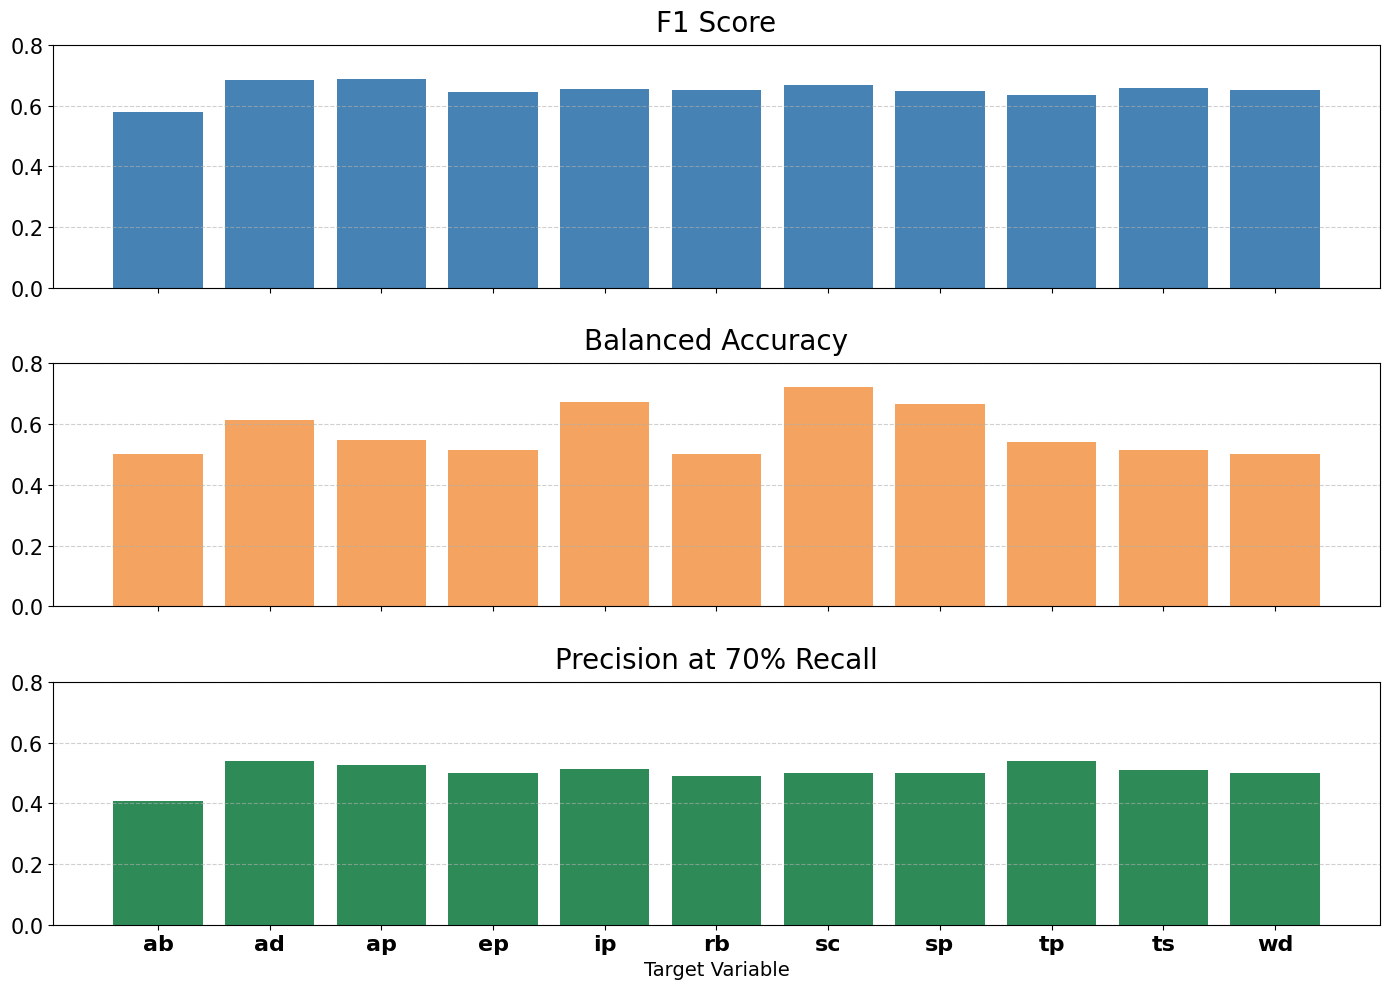

In [21]:
plot_combined_metrics(test)

In [316]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]

    # Extract short two-letter labels (e.g., "sab" → "ab")
    short_labels = [label.split('_')[3] for label in target_order]

    # Metric configurations: (column, plot title, bar color, y-axis label)
    metrics = [
        ("F1", "F1 Score", "dodgerblue", "Score"),
        ("Balanced Accuracy", "Balanced Accuracy", "tan", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "mediumaquamarine", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=13)
    axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()


/tmp/ipykernel_3183052/843420634.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')


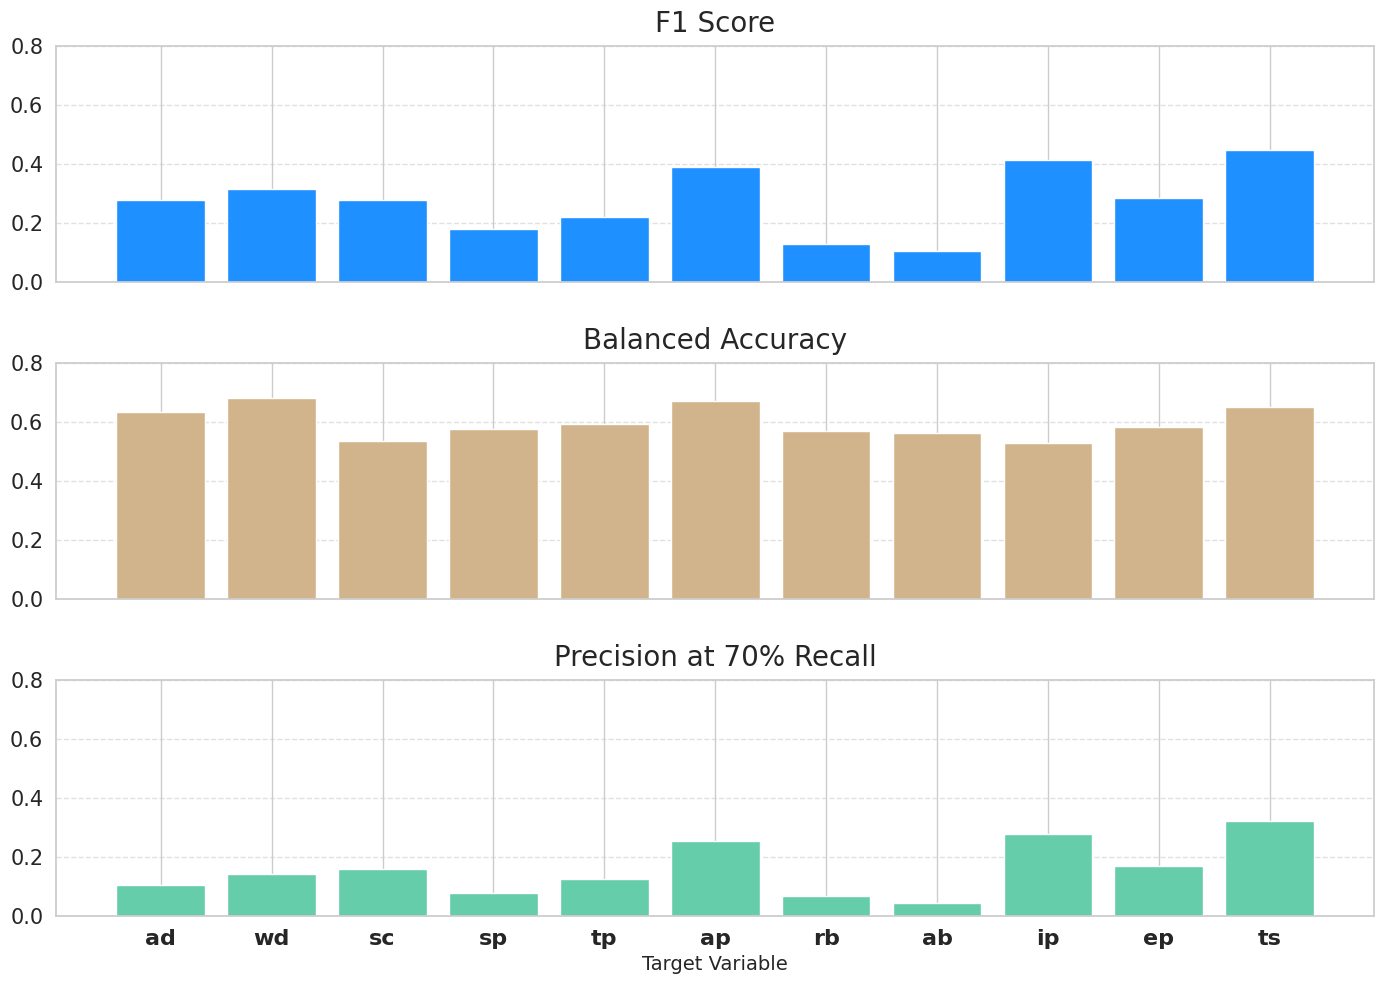

In [317]:
plot_combined_metrics(my_df)

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def plot_top_features_boxplots(df, final_results_df, target):
    # Get top 3 features for the specified target
    row = final_results_df[final_results_df["Target"] == target]
    if row.empty:
        print(f"⚠️ Target {target} not found in results.")
        return

    top_feats = [row["Top Feature 1"].values[0],
                 row["Top Feature 2"].values[0],
                 row["Top Feature 3"].values[0]]

    if target not in df.columns:
        print(f"⚠️ Target {target} not in main DataFrame.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    sns.set(style="whitegrid")

    for i, feat in enumerate(top_feats):
        ax = axes[i]
        if not feat or feat not in df.columns:
            ax.set_visible(False)
            continue

        # Remove extreme outliers using IQR
        Q1 = df[feat].quantile(0.25)
        Q3 = df[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clean_df = df[(df[feat] >= lower_bound) & (df[feat] <= upper_bound)]

        # Mann–Whitney U test
        data = clean_df[[target, feat]].dropna()
        group_0 = data[data[target] == 0][feat]
        group_1 = data[data[target] == 1][feat]

        if len(group_0) >= 5 and len(group_1) >= 5:
            p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')[1]
            p_display = f"(p = {p_value:.3f})" + (" *" if p_value < 0.05 else "")
        else:
            p_display = "(p = NA)"

        title = f"{feat}\n{p_display}"

        # Plotting
        sns.boxplot(x=target, y=feat, hue=target, data=clean_df, ax=ax,
                    palette="Set2", width=0.5, fliersize=3, legend=False)
        sns.stripplot(x=target, y=feat, data=clean_df, ax=ax,
                      jitter=0.25, size=3, color="gray", alpha=0.4)

        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()


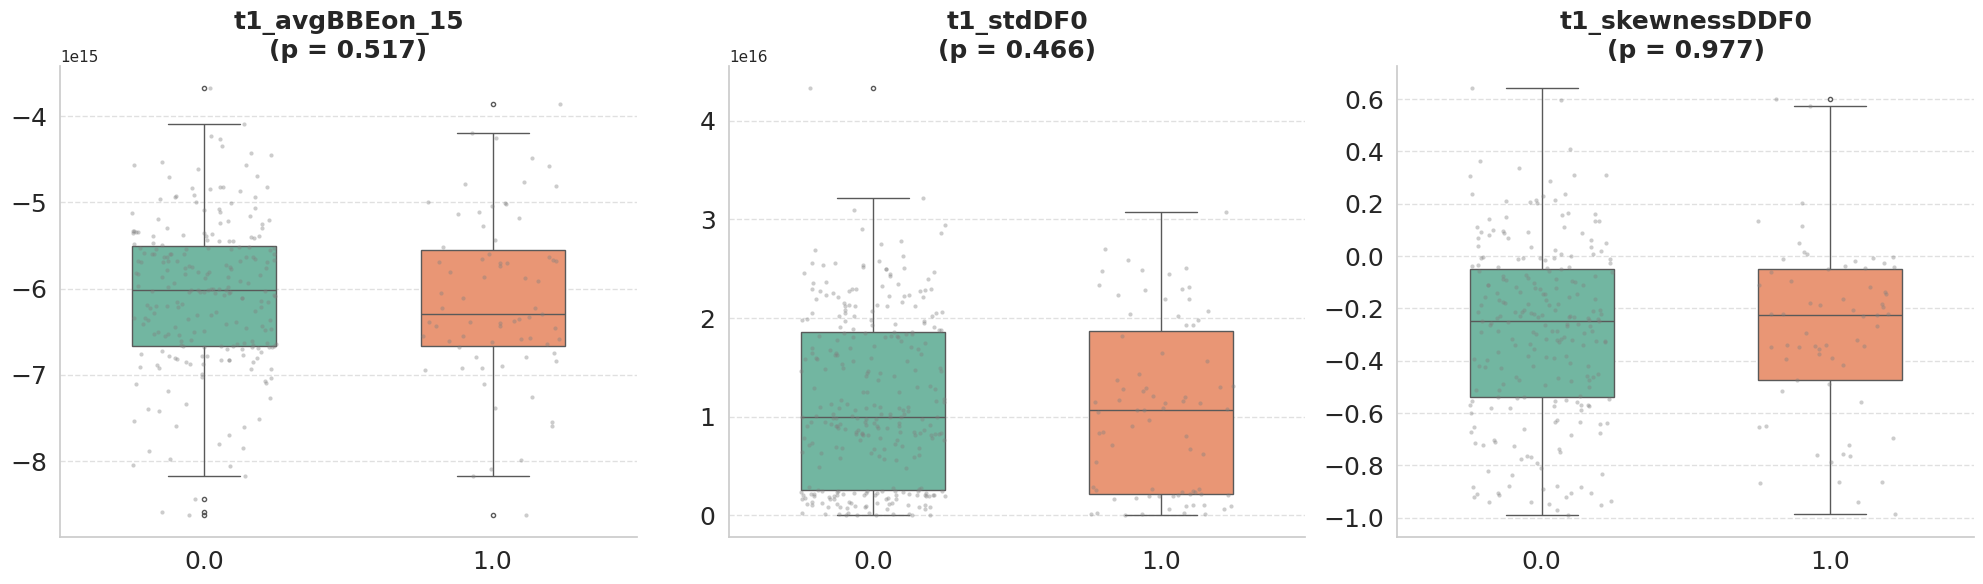

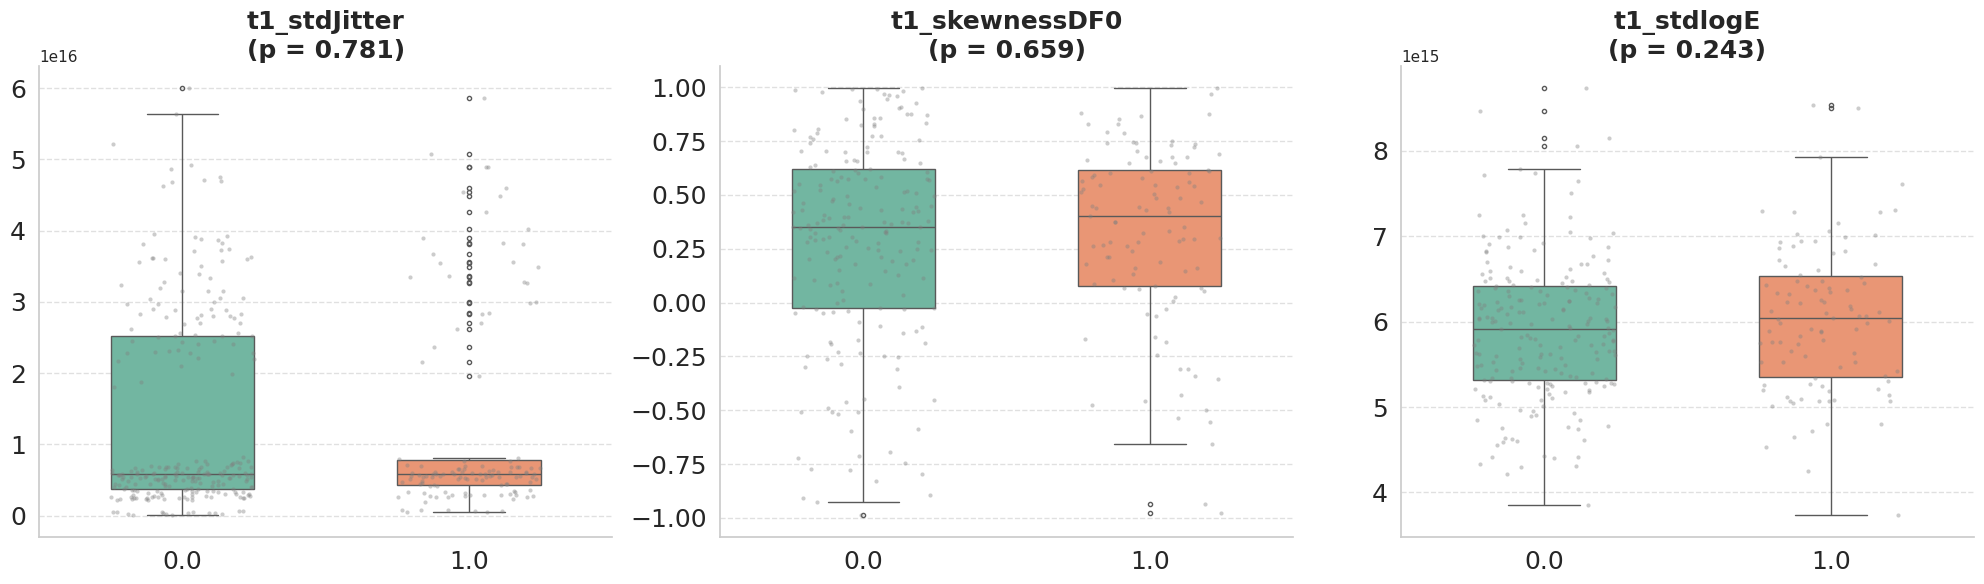

In [179]:
plot_top_features_boxplots(df, final_results_correctt1, target="T1_YSR_93_98_wd")
plot_top_features_boxplots(df, final_results_correctt1, target="T1_YSR_93_98_ip")

In [ ]:
from scipy.stats import mannwhitneyu

# Track p-values
p_values = []
significance_flags = []

for i, row in top_features_df.iterrows():
    target = row["Target"]
    feature = row["Feature"]

    if target not in df.columns or feature not in df.columns:
        p_values.append(None)
        significance_flags.append(False)
        continue

    data = df[[target, feature]].dropna()
    group_0 = data[data[target] == 0][feature]
    group_1 = data[data[target] == 1][feature]

    if len(group_0) < 5 or len(group_1) < 5:
        p_values.append(None)
        significance_flags.append(False)
        continue

    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    p_values.append(p)
    significance_flags.append(p < 0.05)

# Add results to dataframe
top_features_df["P_Value"] = p_values
top_features_df["Significant"] = significance_flags

In [21]:
def extract_top_features_no_pca(df, best_models_df, models, top_n=3):
    results = []
    acoustic_features = df.columns[90:]  # Adjust if needed

    for _, row in best_models_df.iterrows():
        target = row["Target"]
        model_name = row["Model"]

        if "PCA" in model_name:
            continue  # Skip PCA models

        # Prepare data
        data = df[[target]].join(df[acoustic_features]).dropna()
        X = data[acoustic_features]
        y = data[target]

        # Fit the best model
        model = clone(models[model_name])
        model.fit(X, y)

        # Get final logistic regression step
        if hasattr(model, "named_steps"):
            logreg = model.named_steps.get("logreg")
            if logreg is None:
                continue
        else:
            continue  # Not a pipeline

        # Get feature names after kbest (if present)
        if "kbest" in model.named_steps:
            kbest = model.named_steps["kbest"]
            selected_idxs = kbest.get_support(indices=True)
            feature_names = acoustic_features[selected_idxs]
        else:
            feature_names = acoustic_features

        # Extract coefficients
        coefs = logreg.coef_[0]
        top_idx = np.argsort(np.abs(coefs))[-top_n:][::-1]
        top_features = [(feature_names[i], coefs[i]) for i in top_idx]

        for feat, weight in top_features:
            results.append({
                "Target": target,
                "Model": model_name,
                "Feature": feat,
                "Coefficient": weight
            })

    return pd.DataFrame(results)

# Example usage:
top_features_df = extract_top_features_no_pca(df, final_results_df_5050, models)
display(top_features_df)


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

,Target,Model,Feature,Coefficient
0,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_chroma_std_std,-1.432211e-15
1,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_kurtosis,-9.389837e-16
2,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltachroma_1_max,-4.692007e-16
3,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_4_max,1.377422e-12
4,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_11_max,1.043752e-12
5,T1_YSR_sep_binary,KBest - SMOTE,t1_avgDDMFCCon_11,3.582896e-14
6,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEon_9,5.768517e-16
7,T1_YSR_sip_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_max,1.577733e-16
8,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEoff_7,1.537764e-16
9,T1_YSR_srb_binary,No FS - ElasticNet,t1_kurtosisF2,-1.736790e-16


In [25]:
from scipy.stats import mannwhitneyu

# Track p-values
p_values = []
significance_flags = []

for i, row in top_features_df.iterrows():
    target = row["Target"]
    feature = row["Feature"]

    if target not in df.columns or feature not in df.columns:
        p_values.append(None)
        significance_flags.append(False)
        continue

    data = df[[target, feature]].dropna()
    group_0 = data[data[target] == 0][feature]
    group_1 = data[data[target] == 1][feature]

    if len(group_0) < 5 or len(group_1) < 5:
        p_values.append(None)
        significance_flags.append(False)
        continue

    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    p_values.append(p)
    significance_flags.append(p < 0.05)

# Add results to dataframe
top_features_df["P_Value"] = p_values
top_features_df["Significant"] = significance_flags


In [26]:
top_features_df

,Target,Model,Feature,Coefficient,P_Value,P_FDR,Significant_FDR,Significant
0,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_chroma_std_std,-1.432211e-15,0.280046,0.736218,False,False
1,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_kurtosis,-9.389837e-16,0.922301,0.922301,False,False
2,T1_YSR_sab_binary,KBest - ElasticNet,t1_paa_deltachroma_1_max,-4.692007e-16,0.818547,0.879831,False,False
3,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_4_max,1.377422e-12,0.172794,0.736218,False,False
4,T1_YSR_sep_binary,KBest - SMOTE,t1_paa_mfcc_11_max,1.043752e-12,0.651892,0.879831,False,False
5,T1_YSR_sep_binary,KBest - SMOTE,t1_avgDDMFCCon_11,3.582896e-14,0.491925,0.879831,False,False
6,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEon_9,5.768517e-16,0.795153,0.879831,False,False
7,T1_YSR_sip_binary,KBest - ElasticNet,t1_paa_deltaspectral_rolloff_max,1.577733e-16,0.103366,0.736218,False,False
8,T1_YSR_sip_binary,KBest - ElasticNet,t1_skewnessBBEoff_7,1.537764e-16,0.688485,0.879831,False,False
9,T1_YSR_srb_binary,No FS - ElasticNet,t1_kurtosisF2,-1.736790e-16,0.368109,0.736218,False,False


In [29]:
def clean_feature_name(raw_name):
    """Remove prefix from feature name (e.g., 't1_paa_' → '')"""
    return "_".join(raw_name.split("_")[2:])

# Create dictionaries for each target: features and significance
feature_dict = {}
significance_dict = {}

for target in top_features_df["Target"].unique():
    sub_df = top_features_df[top_features_df["Target"] == target]
    features = [f for f in sub_df["Feature"]]
    significance = ["True" if sig else "False" for sig in sub_df["Significant"]]
    feature_dict[target] = features
    significance_dict[target] = significance

# Add to final_results_df_5050
top_features = []
feature_significance = []

for target in final_results_df_5050["Target"]:
    feats = feature_dict.get(target, [])
    sigs = significance_dict.get(target, [])
    
    if feats and sigs:
        top_features.append(", ".join(feats))
        feature_significance.append(", ".join(sigs))
    else:
        top_features.append("")
        feature_significance.append("")

final_results_df_5050["Top Features"] = top_features
final_results_df_5050["Significant"] = feature_significance


In [30]:
final_results_df_5050

,Target,Model,Accuracy,Precision,Recall,F1 (test),Balanced Accuracy (test),Threshold Used,F1 at Threshold,Precision@70%Recall,TP,TN,FP,FN,Top Features,Significant
0,T1_YSR_sab_binary,KBest - ElasticNet,0.406250,0.406250,1.000000,0.577778,0.500000,0.012673,0.577778,0.406250,26,0,38,0,"t1_paa_chroma_std_std, t1_paa_deltaspectral_ro...","False, False, False"
1,T1_YSR_sad_binary,PCA - ElasticNet,0.484375,0.476190,1.000000,0.645161,0.514706,0.005425,0.645161,0.476190,30,1,33,0,,
2,T1_YSR_sap_binary,PCA - Balanced,0.500000,0.500000,1.000000,0.666667,0.500000,0.051699,0.666667,0.500000,32,0,32,0,,
3,T1_YSR_sep_binary,KBest - SMOTE,0.468750,0.468750,1.000000,0.638298,0.500000,0.156437,0.638298,0.473684,30,0,34,0,"t1_paa_mfcc_4_max, t1_paa_mfcc_11_max, t1_avgD...","False, False, False"
4,T1_YSR_sip_binary,KBest - ElasticNet,0.484375,0.467742,1.000000,0.637363,0.528571,0.170850,0.637363,0.473684,29,2,33,0,"t1_skewnessBBEon_9, t1_paa_deltaspectral_rollo...","False, False, False"
5,T1_YSR_srb_binary,No FS - ElasticNet,0.531250,0.508197,1.000000,0.673913,0.545455,0.000814,0.673913,0.568182,31,3,30,0,"t1_kurtosisF2, t1_skewnessDDMFCCoff_12, t1_avg...","False, False, True"
6,T1_YSR_ssc_binary,PCA - SMOTE,0.406250,0.406250,1.000000,0.577778,0.500000,0.003222,0.577778,0.409836,26,0,38,0,,
7,T1_YSR_ssp_binary,KBest - ElasticNet,0.531250,0.452830,0.960000,0.615385,0.608205,0.474286,0.615385,0.461538,24,10,29,1,"t1_skewnessBBEoff_9, t1_avgDDMFCCoff_4, t1_avg...","False, False, False"
8,T1_YSR_stp_binary,PCA - Balanced,0.468750,0.460317,1.000000,0.630435,0.514286,0.036601,0.630435,0.460317,29,1,34,0,,
9,T1_YSR_sts_binary,PCA - SMOTE,0.531250,0.508475,0.967742,0.666667,0.544477,0.080457,0.666667,0.518519,30,4,29,1,,


In [3]:
####GENERATE PQ LABELS
# Step 1: Identify the cleaned acoustic feature names
acoustic_cols_baseline_raw = df_baseline.columns[60:]
acoustic_cols_t1_raw = df_t1.columns[79:]

def strip_prefix(cols, prefix):
    return [col[len(prefix):] if col.startswith(prefix) else col for col in cols]

baseline_clean_names = strip_prefix(acoustic_cols_baseline_raw, "baseline_")
t1_clean_names = strip_prefix(acoustic_cols_t1_raw, "t1_")

# Step 2: Find 999 common features
common_features = list(set(baseline_clean_names).intersection(set(t1_clean_names)))

# Step 3: Map back to original column names
baseline_feature_map = {col: col[len("baseline_"):] if col.startswith("baseline_") else col for col in acoustic_cols_baseline_raw}
t1_feature_map = {col: col[len("t1_"):] if col.startswith("t1_") else col for col in acoustic_cols_t1_raw}

baseline_common_cols = [col for col in acoustic_cols_baseline_raw if baseline_feature_map[col] in common_features]
t1_common_cols = [col for col in acoustic_cols_t1_raw if t1_feature_map[col] in common_features]

# Step 4: Align both DataFrames by ID
common_ids = set(df_baseline["ID_Alexandra"]).intersection(df_t1["ID_Alexandra"])
df_base_common = df_baseline[df_baseline["ID_Alexandra"].isin(common_ids)].copy()
df_t1_common = df_t1[df_t1["ID_Alexandra"].isin(common_ids)].copy()

df_base_common.set_index("ID_Alexandra", inplace=True)
df_t1_common.set_index("ID_Alexandra", inplace=True)

# Step 5: Compute clinical score differences
pq16_diff = (df_t1_common["PQ16_sum"] - df_base_common["PQ16_sum"]).rename("PQ16_sum_diff")
pq14_delusions_diff = (df_t1_common["T1_PQ14_delusions"] - df_base_common["PQ14_delusions"]).rename("PQ14_delusions_diff")
pq14_hallucinations_diff = (df_t1_common["T1_PQ14_hallucinations"] - df_base_common["PQ14_hallucinations"]).rename("PQ14_hallucinations_diff")

# Step 6: Compute acoustic feature differences
baseline_features = df_base_common[baseline_common_cols]
baseline_features.columns = [baseline_feature_map[col] for col in baseline_common_cols]

t1_features = df_t1_common[t1_common_cols]
t1_features.columns = [t1_feature_map[col] for col in t1_common_cols]

acoustic_diff = t1_features[common_features] - baseline_features[common_features]
acoustic_diff.columns = [col + "_diff" for col in acoustic_diff.columns]

# Step 7: Final output
df_diff_final = pd.concat([
    pq16_diff,
    pq14_delusions_diff,
    pq14_hallucinations_diff,
    acoustic_diff
], axis=1).reset_index()

# Preview
print("Final shape:", df_diff_final.shape)
df_diff_final.head()


Final shape: (333, 1003)


,ID_Alexandra,PQ16_sum_diff,PQ14_delusions_diff,PQ14_hallucinations_diff,skewnessMFCCon_1_diff,avgBBEon_1_diff,paa_mfcc_5_skew_diff,paa_deltaspectral_flux_mean_diff,paa_deltamfcc_13_min_diff,avgMFCCoff_1_diff,...,skewnessBBEoff_20_diff,paa_deltamfcc_10_std_diff,paa_chroma_3_mean_diff,paa_chroma_10_kurtosis_diff,paa_mfcc_13_skew_diff,avgBBEon_4_diff,skwEunvoiced_diff,avg1Eunvoiced_diff,paa_deltamfcc_3_max_diff,avgMFCCoff_12_diff
0,5,-3.0,-1.0,-1.0,-3.433926e+16,-2.883795e+16,0.235740,1.098701e+10,0.235843,2.343557e-01,...,6.989415e-01,-0.010148,0.016085,1.522832e+16,-0.069722,-2.888216e+15,0.232813,-4.866883e+15,3.267627e+15,1.630542e+00
1,6,-1.0,0.0,0.0,-2.540848e+14,-2.286317e+16,0.295497,9.166863e+06,0.226769,3.941781e-02,...,3.596131e-01,0.000307,0.040003,3.521585e+16,0.045685,-3.323129e+16,0.056739,-4.297211e+15,2.502497e+16,-2.210704e+12
2,8,-1.0,-1.0,0.0,-2.392799e+16,-2.500517e+16,0.208468,7.920860e+08,0.105345,-1.070487e+16,...,1.181705e+16,0.035366,0.007604,1.156076e+16,0.073629,-3.454860e+16,0.006422,-4.308319e+16,3.032630e+15,6.854161e-01
3,14,-2.0,-1.0,0.0,-3.308535e+16,-3.157661e+16,0.245915,2.389225e+08,-0.108592,2.609392e+00,...,2.832557e-01,0.009020,0.000510,2.914917e+15,-0.068299,-3.526802e+16,0.316033,-5.108996e+16,2.599058e+15,-1.887356e+16
4,15,-5.0,-1.0,-4.0,-2.110423e+16,-2.375734e+16,0.473061,3.332234e+09,0.250129,5.997232e-01,...,4.287074e-01,0.010615,-0.010817,8.061446e+14,0.565191,-3.672531e+16,0.061228,-4.237167e+16,2.848256e+16,2.305404e-01


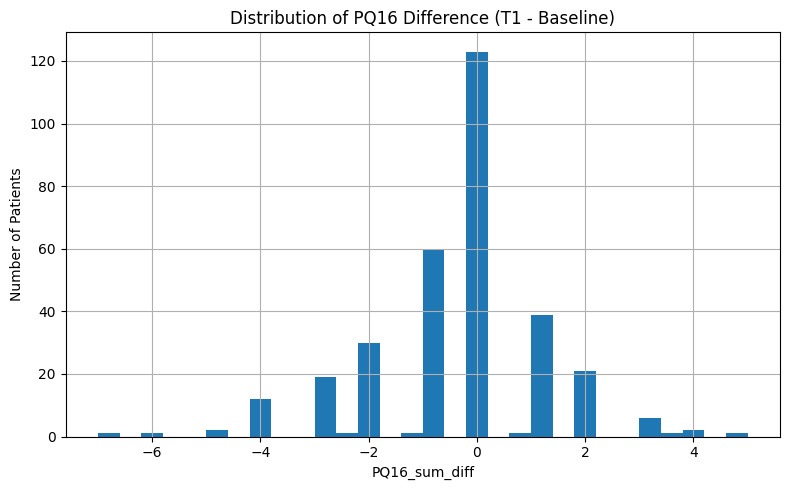

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_diff_final["PQ14_hallucinations_diff"].dropna(), bins=30)
plt.title("Distribution of PQ16 Difference (T1 - Baseline)")
plt.xlabel("PQ16_sum_diff")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Step: Compute quantiles
q25_16 = df_diff_final["PQ16_sum_diff"].quantile(0.2)
q75_16 = df_diff_final["PQ16_sum_diff"].quantile(0.8)

q25_del = df_diff_final["PQ14_delusions_diff"].quantile(0.2)
q75_del = df_diff_final["PQ14_delusions_diff"].quantile(0.8)

q25_hal = df_diff_final["PQ14_hallucinations_diff"].quantile(0.2)
q75_hal = df_diff_final["PQ14_hallucinations_diff"].quantile(0.8)

# Step: Define assignment
def assign_group(x, q25, q75):
    if x <= q25:
        return 0
    elif x >= q75:
        return 1
    else:
        return np.nan

# Step: Assign and insert all three group columns after PQ14_hallucinations_diff
insert_at = df_diff_final.columns.get_loc("PQ14_hallucinations_diff") + 1

df_diff_final.insert(
    insert_at,
    "group_PQ16",
    df_diff_final["PQ16_sum_diff"].apply(assign_group, args=(q25_16, q75_16)).astype("Int64")
)

df_diff_final.insert(
    insert_at + 1,
    "group_delusions",
    df_diff_final["PQ14_delusions_diff"].apply(assign_group, args=(q25_del, q75_del)).astype("Int64")
)

df_diff_final.insert(
    insert_at + 2,
    "group_hallucinations",
    df_diff_final["PQ14_hallucinations_diff"].apply(assign_group, args=(q25_hal, q75_hal)).astype("Int64")
)

# Preview
print("Final shape with inserted group columns:", df_diff_final.shape)
df_diff_final.loc[:, ["PQ14_hallucinations_diff", "group_PQ16", "group_delusions", "group_hallucinations"]].head()


Final shape with inserted group columns: (333, 1006)


,PQ14_hallucinations_diff,group_PQ16,group_delusions,group_hallucinations
0,-1.0,0,0,<NA>
1,0.0,<NA>,<NA>,<NA>
2,0.0,<NA>,0,<NA>
3,0.0,<NA>,0,<NA>
4,-4.0,0,0,0


In [6]:
df_diff_final

,ID_Alexandra,PQ16_sum_diff,PQ14_delusions_diff,PQ14_hallucinations_diff,group_PQ16,group_delusions,group_hallucinations,skewnessMFCCon_1_diff,avgBBEon_1_diff,paa_mfcc_5_skew_diff,...,skewnessBBEoff_20_diff,paa_deltamfcc_10_std_diff,paa_chroma_3_mean_diff,paa_chroma_10_kurtosis_diff,paa_mfcc_13_skew_diff,avgBBEon_4_diff,skwEunvoiced_diff,avg1Eunvoiced_diff,paa_deltamfcc_3_max_diff,avgMFCCoff_12_diff
0,5,-3.0,-1.0,-1.0,0,0,<NA>,-3.433926e+16,-2.883795e+16,0.235740,...,6.989415e-01,-0.010148,0.016085,1.522832e+16,-0.069722,-2.888216e+15,0.232813,-4.866883e+15,3.267627e+15,1.630542e+00
1,6,-1.0,0.0,0.0,<NA>,<NA>,<NA>,-2.540848e+14,-2.286317e+16,0.295497,...,3.596131e-01,0.000307,0.040003,3.521585e+16,0.045685,-3.323129e+16,0.056739,-4.297211e+15,2.502497e+16,-2.210704e+12
2,8,-1.0,-1.0,0.0,<NA>,0,<NA>,-2.392799e+16,-2.500517e+16,0.208468,...,1.181705e+16,0.035366,0.007604,1.156076e+16,0.073629,-3.454860e+16,0.006422,-4.308319e+16,3.032630e+15,6.854161e-01
3,14,-2.0,-1.0,0.0,<NA>,0,<NA>,-3.308535e+16,-3.157661e+16,0.245915,...,2.832557e-01,0.009020,0.000510,2.914917e+15,-0.068299,-3.526802e+16,0.316033,-5.108996e+16,2.599058e+15,-1.887356e+16
4,15,-5.0,-1.0,-4.0,0,0,0,-2.110423e+16,-2.375734e+16,0.473061,...,4.287074e-01,0.010615,-0.010817,8.061446e+14,0.565191,-3.672531e+16,0.061228,-4.237167e+16,2.848256e+16,2.305404e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,1009,1.0,0.0,1.0,1,<NA>,1,-3.273474e+15,-1.134600e+16,0.968395,...,1.517864e+16,-0.010217,-0.059575,8.188095e+14,0.769485,-3.503316e+16,0.096184,-4.422424e+15,2.401526e+16,-1.089489e+00
329,1016,0.0,0.0,0.0,<NA>,<NA>,<NA>,-4.346155e+15,-3.728339e+15,0.231494,...,1.560002e+16,-0.012728,-0.018193,9.752618e+15,0.455659,-4.919892e+15,0.256320,-6.016198e+15,3.081138e+15,2.802194e+00
330,1017,-3.0,-1.0,-1.0,0,0,<NA>,-2.297415e+16,-3.157636e+16,0.164342,...,5.146615e-02,0.003718,0.000400,5.637213e+16,0.169310,-3.654815e+16,0.080208,-5.968195e+15,3.191767e+16,1.199678e+16
331,1018,1.0,0.0,0.0,1,<NA>,<NA>,-3.374897e+16,-2.318353e+15,-0.011269,...,6.046379e-01,-0.029077,0.028764,5.676620e+15,0.112775,-3.128527e+16,0.300876,-3.369967e+15,2.977486e+15,9.183044e-01


In [8]:
group_cols = ['group_PQ16', 'group_delusions', 'group_hallucinations']

for col in group_cols:
    counts = df_diff_final[col].value_counts(dropna=True)
    print(f"\n{col}:")
    print(f"0s: {counts.get(0, 0)}")
    print(f"1s: {counts.get(1, 0)}")



group_PQ16:
0s: 65
1s: 88

group_delusions:
0s: 100
1s: 76

group_hallucinations:
0s: 66
1s: 70


In [7]:
value_counts = df_diff_final['group_hallucinations'].value_counts(dropna=False)

# Rename index so <NA> appears as string for clarity (optional)
value_counts.index = value_counts.index.map(lambda x: '<NA>' if pd.isna(x) else x)

print(value_counts)


group_hallucinations
<NA>    197
1.0      70
0.0      66
Name: count, dtype: Int64


# running the 9 logreg variations with PQ16

In [ ]:
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn import FunctionSampler
from collections import Counter

from joblib import Parallel, delayed


def evaluate_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, min_precision, min_recall, recall_target):
    model_fold = clone(model)
    model_fold.fit(X_train_fold, y_train_fold)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba_val)
    f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= min_precision and r >= min_recall]

    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1s[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]
    else:
        threshold = 0.5

    y_pred_val = (y_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val_fold, y_pred_val, zero_division=0)
    precision = precision_score(y_val_fold, y_pred_val, zero_division=0)
    recall = recall_score(y_val_fold, y_pred_val, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    prec_at_70 = precision if recall >= recall_target else np.nan

    return f1, prec_at_70, threshold, bal_acc

# Updated cross_val_with_threshold_tuning with n_jobs
def cross_val_with_threshold_tuning(model, X, y, min_precision=0.3, min_recall=0.3, recall_target=0.7, n_splits=5, n_jobs=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_fold)(
            model,
            X.iloc[train_idx], y.iloc[train_idx],
            X.iloc[val_idx], y.iloc[val_idx],
            min_precision, min_recall, recall_target
        )
        for train_idx, val_idx in kf.split(X, y)
    )

    f1_scores, precisions_at_70recall, thresholds_used, bal_accs = zip(*results)

    return {
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Balanced Accuracy Mean": np.mean(bal_accs),
        "Balanced Accuracy Std": np.std(bal_accs),
        "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
        "Thresholds Used (Mean)": np.mean(thresholds_used)
    }

from imblearn.over_sampling import SMOTE

def safe_smote(X, y, random_state=42):
    # Count minority class samples
    from collections import Counter
    counter = Counter(y)
    min_class_count = min(counter.values())

    # Avoid errors by capping k_neighbors
    k = min(3, min_class_count - 1) if min_class_count > 1 else 1

    return SMOTE(k_neighbors=k, random_state=random_state).fit_resample(X, y)
cv_results = []
models_5050 = {
    "No FS": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "No FS - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "KBest": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KBest - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "PCA": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "PCA - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ])
}
targets_5050 = ['group_PQ16', 'group_delusions', 'group_hallucinations']

# Automatically get acoustic feature columns (assumes ID, PQ16_diff, group are first 3)
acoustic_features = df_diff_final.columns[7:]


for target in tqdm(targets_5050):
    data = df_diff_final[[target]].join(df_diff_final[df_diff_final.columns[7:]]).dropna()
    y = data[target]
    X = data[df_diff_final.columns[7:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models_5050.items():
        metrics = cross_val_with_threshold_tuning(
            model, X_train, y_train,  # <- important: use training set only
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        cv_results.append({
            "Target": target,
            "Model": model_name,
            "F1 Mean": metrics["F1 Mean"],
            "F1 Std": metrics["F1 Std"],
            "Balanced Accuracy Mean": metrics["Balanced Accuracy Mean"],
            "Balanced Accuracy Std": metrics["Balanced Accuracy Std"],
            "Precision@70%Recall Mean": metrics["Precision@70%Recall Mean"],
            "Thresholds Used (Mean)": metrics["Thresholds Used (Mean)"]
        })

# Final results per model and target
cv_df_5050 = pd.DataFrame(cv_results)
#cv_df_5050.to_csv("CV_BASELINE_all_models_5050.csv", index=False)
# Example: find best model per target
best_models_df_5050 = cv_df_5050.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()

final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models_5050[model_name])

    # Prepare data
    data = df_diff_final[[target]].join(df_diff_final[df_diff_final.columns[7:]]).dropna()
    y = data[target]
    X = data[df_diff_final.columns[7:]]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit model
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Threshold tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5
        best_f1 = np.nan

    # Predict with threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

    # Precision at 70% recall
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= 0.7]
    precision_at_70recall = max([precisions[i] for i in valid_idxs_70]) if valid_idxs_70 else np.nan

    # Confusion matrix
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # ---- Extract Top 3 Features (keep full names) ----
    if "PCA" not in model_name:
        try:
            coefs = model.named_steps["logreg"].coef_[0] if hasattr(model, "named_steps") else model.coef_[0]
            feature_names = X.columns
            sorted_indices = np.argsort(np.abs(coefs))[::-1][:3]
            top_features = [feature_names[i] for i in sorted_indices]
            top_coefs = [coefs[i] for i in sorted_indices]
        except Exception as e:
            print(f"⚠️ Feature extraction failed for {target}: {e}")
            top_features = [""] * 3
            top_coefs = [np.nan] * 3
    else:
        top_features = [""] * 3
        top_coefs = [np.nan] * 3

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec_at_thresh,
        "Recall": recall_at_thresh,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "Top Feature 1": top_features[0],
        "Top Feature 2": top_features[1],
        "Top Feature 3": top_features[2],
        "Coef 1": top_coefs[0],
        "Coef 2": top_coefs[1],
        "Coef 3": top_coefs[2],
    })

# Final dataframe
final_results_correctt0_THIS = pd.DataFrame(final_results)
#final_results_correctt0_THIS.to_csv("5050505050FINAL_TEST_with_features_BASELINE.csv", index=False)
final_results_correctt0_THIS.to_csv("PQ_EXPERIMENTS.csv", index=False)
import matplotlib.pyplot as plt

In [41]:
def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]
    short_labels = [label.split('_')[1] for label in target_order]

    # Metric configurations
    metrics = [
        ("F1", "F1 Score", "thistle", "Score"),                # softer purple
        ("Balanced Accuracy", "Balanced Accuracy", "lightcoral", "Score"),  # softer red/tomato
        ("Precision@70%Recall", "Precision at 70% Recall", "darkseagreen", "Precision")  # softer green
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        #ax.set_ylabel(ylabel, fontsize=14)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=11)

    # Make x-axis labels bold
    axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()

/tmp/ipykernel_1491282/1466653555.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')


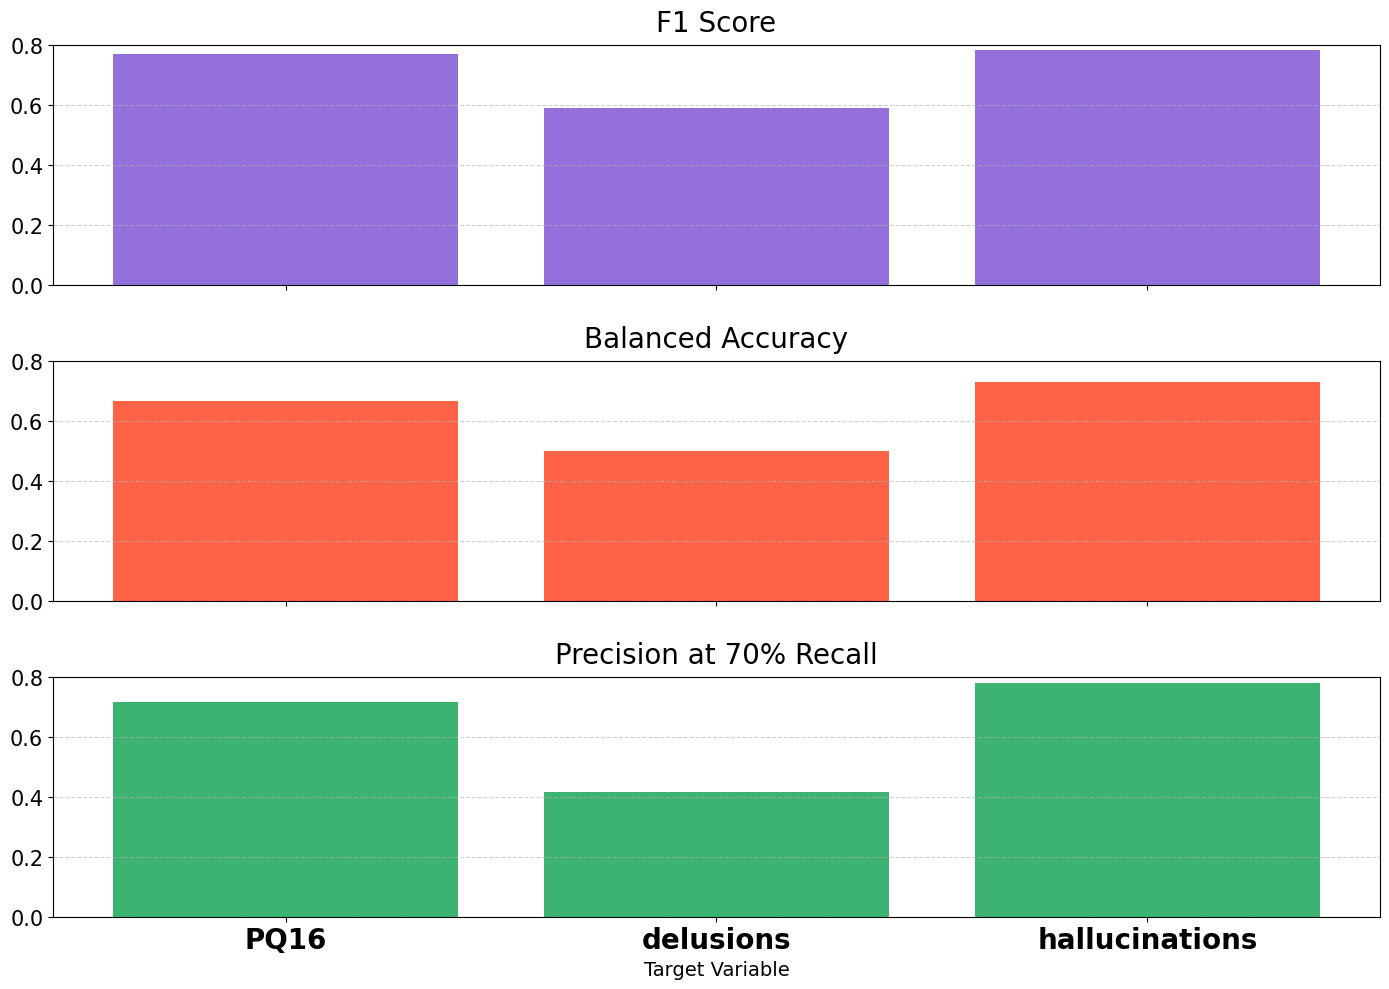

In [32]:
plot_combined_metrics(final_results_correctt0_THIS)

In [8]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, balanced_accuracy_score,
    accuracy_score, confusion_matrix, precision_recall_curve
)
from xgboost import XGBClassifier
from tqdm import tqdm
import pandas as pd
import numpy as np

feature_cols = df_diff_final.columns[7:]  # Adjust if needed

k_values = [30, 50, 100]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
targets_5050 = ['group_PQ16', 'group_delusions', 'group_hallucinations']
for target in tqdm(targets_5050):
    data = df_diff_final[[target] + list(feature_cols)].dropna()
    y_all = data[target]
    X_all = data[feature_cols]

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
    )

    best_f1 = -np.inf
    best_k = None
    best_threshold = 0.5

    for k in k_values:
        fold_metrics = []

        for train_idx, val_idx in cv.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
            y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            selector = SelectKBest(score_func=mutual_info_classif, k=k)
            X_train_sel = selector.fit_transform(X_train_scaled, y_train)
            X_val_sel = selector.transform(X_val_scaled)

            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='aucpr',
                tree_method='hist',
                device='cuda',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                verbosity=0,
                random_state=42
            )
            model.fit(X_train_sel, y_train)
            y_proba = model.predict_proba(X_val_sel)[:, 1]

            precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba)
            f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
            valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

            threshold = 0.5
            if valid_idxs:
                best_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
                threshold = thresholds[best_idx]

            y_pred = (y_proba >= threshold).astype(int)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            fold_metrics.append(f1)

        avg_f1 = np.mean(fold_metrics)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_k = k

    # Final model on trainval, test on holdout
    scaler = RobustScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    selector = SelectKBest(score_func=mutual_info_classif, k=best_k)
    X_trainval_sel = selector.fit_transform(X_trainval_scaled, y_trainval)

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        device='cuda',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        verbosity=0,
        random_state=42
    )
    model.fit(X_trainval_sel, y_trainval)

    X_test_scaled = scaler.transform(X_test)
    X_test_sel = selector.transform(X_test_scaled)
    y_proba_test = model.predict_proba(X_test_sel)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    threshold = 0.5
    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]

    y_pred_test = (y_proba_test >= threshold).astype(int)

    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    acc = accuracy_score(y_test, y_pred_test)
    precision_at_70 = precision if recall >= 0.7 else np.nan
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X_all.columns[selected_feature_indices]
    importances = model.get_booster().get_score(importance_type='gain')
    feature_importance = {
    selected_feature_names[int(k[1:])]: v for k, v in importances.items()}


    results.append({
        "Target": target,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Threshold": threshold,
        "k": best_k,
        "Selected Features": list(selected_feature_names),
        "Feature Importances": feature_importance
    })

results_df = pd.DataFrame(results)
######checkpoint

100%|██████████| 3/3 [02:40<00:00, 53.46s/it]


/tmp/ipykernel_1491282/268588528.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')


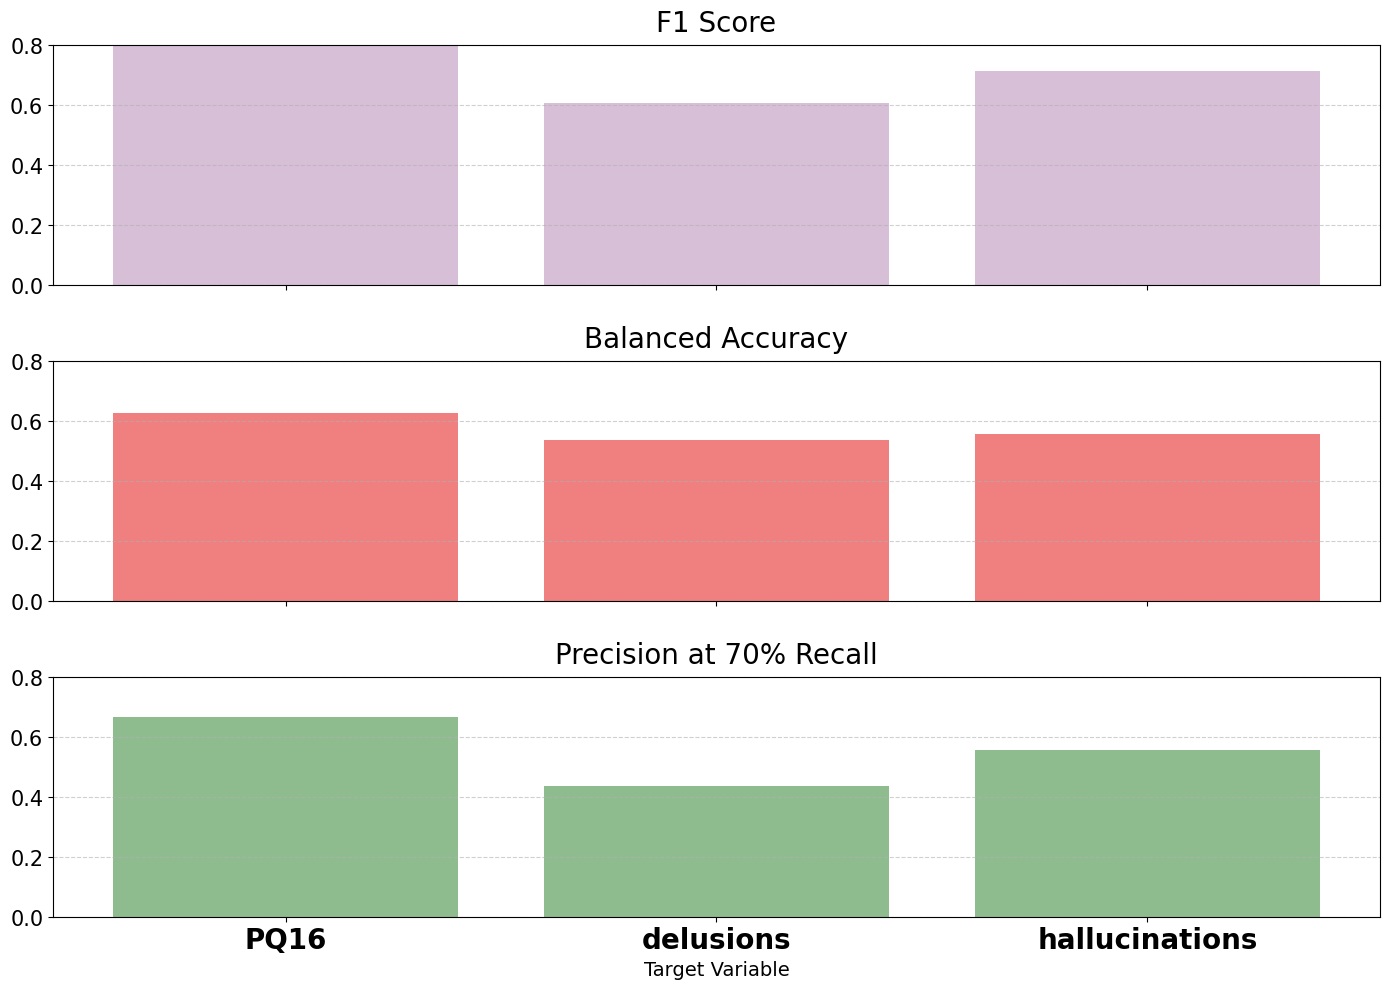

In [42]:
plot_combined_metrics(results_df)